[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hoihui/tutorial/blob/master/GAN.ipynb)

In [26]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [133]:
# !pip3 install -U torch torchvision
import torch
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.__version__, cuda

('1.1.0', True)

In [1]:
# !pip install -q tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
tf.__version__

'2.0.0-alpha0'

# MNIST, MLP

[Reference](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/gan-mnist/MNIST_GAN_Solution.ipynb)
* One network (D) takes in an image and output Prob(it is real)
* Another network takes in random numbers and output an image with the objective that D(img) gives high P(real)

In [0]:
import torch

imgsize = 28
batch_size = 64  # how many samples per batch to load
z_size = 28*28
print_every=100
epochs = 5
patience = 2  #early stopping
lr = 0.002

## Load Data

In [191]:
from torchvision import datasets, transforms

train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
print(len(train_data))

60000


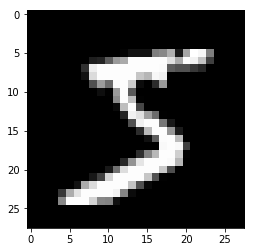

In [192]:
#visualize
images, labels = next(iter(train_loader))
plt.imshow(np.squeeze(images[0]), cmap='gray')

## Model

### Discriminator

linear classifier, with 3 hidden layers, using [Leaky Relu](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU) activation, where for $x<0$ the slope is slightly positive

outputs single number indicating *real*/*fake*

In [193]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim=32, output_size=1):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)        
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        self.dropout = nn.Dropout(0.3)        
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        
        return self.fc4(x)

D = Discriminator(input_size=784, hidden_dim=32, output_size=1).to(device)
print(D)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.0)
)


In [194]:
images, labels = next(iter(train_loader))
print(images.shape)
print(D(images.to(device)).shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 1])


### Generator

* inputs 784 random numbers, outputs 784 pixels
* Use `torch.tanh` instead of `torch.sigmoid` for output (why?)

In [195]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim=32, output_size=784):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        
        return torch.tanh(self.fc4(x))

G = Generator(input_size=784, hidden_dim=32, output_size=784).to(device)
print(G)

Generator(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3)
)


### Losses

* Use BCEWithLogitsLoss since D outputs just a number
* To help D generalize better, the true labels are **reduced from 1.0 to 0.9**
* Use different optimizer objects for Discriminator and Generator

In [0]:
d_criterion = lambda pred, true: nn.BCEWithLogitsLoss()(pred,true*0.9)
g_criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr)
g_optimizer = torch.optim.Adam(G.parameters(), lr)

## Train

In [0]:
# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=8
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
def view_samples(epoch, samples, nrows=2, ncols=4):
    fig, axes = plt.subplots(figsize=(1.5*ncols,1.5*nrows), nrows=nrows, ncols=ncols, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.cpu().detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    plt.show()

In [198]:
samples = []   # saves samples so visualize how the image quality improves over epochs

D.train()
G.train()
for epoch in range(epochs):
    for batch_i, (real_images, _) in enumerate(train_loader):                
        batch_size = real_images.size(0)        
        real_images = real_images*2 - 1  # rescale to [-1, 1) as G generates to this range
        
        # ===========TRAIN THE GENERATOR=============
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))  #generates fake img
        z = torch.from_numpy(z).float()
        fake_images = G(z.to(device))
        
        g_optimizer.zero_grad()
        pred = D(fake_images.to(device)).squeeze()
        g_loss = g_criterion(pred, torch.ones(batch_size).to(device)) #min loss -> make D think the images are real        
        g_loss.backward()
        g_optimizer.step()
        
        # ============TRAIN THE DISCRIMINATOR=========        
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))  #generates fake img
        z = torch.from_numpy(z).float()
        fake_images = G(z.to(device)).view_as(real_images)
        
        allimages = torch.cat((real_images.to(device), fake_images.to(device)), 0)  #concat on 0th axis
        alllabels = torch.cat((torch.ones(batch_size),torch.zeros(batch_size)), 0).to(device)
        
        d_optimizer.zero_grad()
        pred = D(allimages.to(device)).squeeze()
        d_loss = d_criterion(pred,alllabels)
        d_loss.backward()
        d_optimizer.step()

        # ===================OUTPUT===================        
        if batch_i % print_every == 0:
            print(f'Epoch {epoch+1:5d} | d_loss: {d_loss.item():6.4f} | g_loss: {g_loss.item():6.4f}')
    break
    from IPython.display import clear_output
    clear_output()
    G.eval()
    samples += G(fixed_z.to(device)),
    G.train()
    view_samples(-1,samples,1,8)

Epoch     1 | d_loss: 0.6978 | g_loss: 0.6674
Epoch     1 | d_loss: 0.7559 | g_loss: 0.6102
Epoch     1 | d_loss: 0.8807 | g_loss: 1.7584
Epoch     1 | d_loss: 1.9325 | g_loss: 0.4743
Epoch     1 | d_loss: 0.3199 | g_loss: 5.5182
Epoch     1 | d_loss: 0.3948 | g_loss: 3.2177
Epoch     1 | d_loss: 0.2708 | g_loss: 2.7143
Epoch     1 | d_loss: 0.5104 | g_loss: 3.5704
Epoch     1 | d_loss: 0.3260 | g_loss: 4.0445
Epoch     1 | d_loss: 0.7104 | g_loss: 2.3748


In [199]:
# shows equivalence to https://github.com/udacity/deep-learning-v2-pytorch/blob/master/gan-mnist/MNIST_GAN_Solution.ipynb
# D.eval() # set dropout=0
allimages = torch.cat((real_images.to(device), fake_images.to(device)), 0)  #concat on 0th axis
alllabels = torch.cat((torch.ones(batch_size),torch.zeros(batch_size)), 0).to(device)
pred = D(allimages.to(device)).squeeze()
print(d_criterion(pred,alllabels))
D_real = D(allimages[:batch_size])
D_fake = D(allimages[batch_size:])
print((real_loss(D_real, smooth=True)+fake_loss(D_fake))/2)

tensor(0.2706, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.2706, device='cuda:0', grad_fn=<DivBackward0>)


## Evaluate

### Visualize training progress

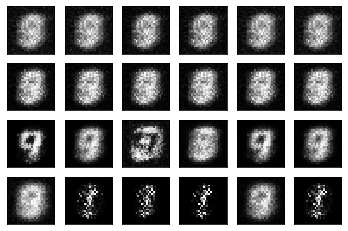

In [24]:
nrows = 4 # split epochs into 10, so 100/10 = every 10 epochs
ncols = 6
fig, axes = plt.subplots(figsize=(ncols,nrows), nrows=nrows, ncols=ncols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/nrows)], axes):
    for img, ax in zip(sample[::int(len(sample)/ncols)], ax_row):
        img = img.cpu().detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

### Generate new

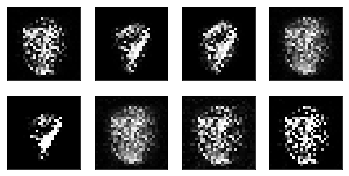

In [25]:
G.eval()

sample_size=8
rand_z = np.random.uniform(-1, 1, size=(sample_size, imgsize*imgsize))
rand_z = torch.from_numpy(rand_z).float()
rand_images = G(rand_z.to(device))

view_samples(0, [rand_images])

# MNIST, Convolutional

https://www.tensorflow.org/alpha/tutorials/generative/dcgan

## Load Data

In [3]:
(train_images, train_labels), _ = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5     # to [-1, 1]

In [21]:
BATCH_SIZE=256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(BATCH_SIZE)

## Model

### Generator

In [7]:
G = tf.keras.Sequential()
G.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
G.add(tf.keras.layers.BatchNormalization())
G.add(tf.keras.layers.LeakyReLU())

G.add(tf.keras.layers.Reshape((7, 7, 256))) #output_shape == (None, 7, 7, 256), None is the batch size

G.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) #output_shape == (None, 7, 7, 128)
G.add(tf.keras.layers.BatchNormalization())
G.add(tf.keras.layers.LeakyReLU())

G.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)) #output_shape == (None, 14, 14, 64)
G.add(tf.keras.layers.BatchNormalization())
G.add(tf.keras.layers.LeakyReLU())

G.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')) #output_shape == (None, 28, 28, 1)

G.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_v2 (Batc (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)        

### Discriminator

In [8]:
D = tf.keras.Sequential()
D.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                             input_shape=[28, 28, 1]))
D.add(tf.keras.layers.LeakyReLU())
D.add(tf.keras.layers.Dropout(0.3))

D.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
D.add(tf.keras.layers.LeakyReLU())
D.add(tf.keras.layers.Dropout(0.3))

D.add(tf.keras.layers.Flatten())
D.add(tf.keras.layers.Dense(1))

D.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

In [12]:
# test
print(D(G(tf.random.normal([1, 100]), training=False)))

tf.Tensor([[0.00056085]], shape=(1, 1), dtype=float32)


### Losses

In [17]:
criterion = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def d_loss(real_output, fake_output):
    real_loss = criterion(tf.ones_like(real_output), real_output)
    fake_loss = criterion(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def g_loss(fake_output):
    return criterion(tf.ones_like(fake_output), fake_output)

In [14]:
d_optimizer = tf.keras.optimizers.Adam(1e-4)
g_optimizer = tf.keras.optimizers.Adam(1e-4)

## Train

In [15]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [23]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        generated_images = G(noise, training=True)

        real_output = D(images, training=True)
        fake_output = D(generated_images, training=True)

        g_loss_ = g_loss(fake_output)
        d_loss_ = d_loss(real_output, fake_output)

    grad_g = g_tape.gradient(g_loss_, G.trainable_variables)
    grad_d = d_tape.gradient(d_loss_, D.trainable_variables)

    g_optimizer.apply_gradients(zip(grad_g, G.trainable_variables))
    d_optimizer.apply_gradients(zip(grad_d, D.trainable_variables))

In [ ]:
from IPython.display import clear_output
for _ in range(epochs):
    for image_batch in train_dataset:
        train_step(image_batch)

    clear_output(wait=True)
    gen = G(seed, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(gen.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(gen[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()

# Street View House Number, Convolutional

[Reference](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/dcgan-svhn/DCGAN_Solution.ipynb)
* Discriminator uses Convolution layers with Batch Normalization
* Generator uses ConvTranspose2d to increase width/heights gradually to a full image

In [0]:
batch_size = 128
imgsize = [3,32,32]
z_size = 100
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

print_every = 300
epochs = 50

## Data

In [201]:
from torchvision import datasets, transforms
from itertools import chain

data = datasets.SVHN(root='~/.pytorch/SVHN_data/', split='train', download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=data, batch_size=batch_size, shuffle=True)

Using downloaded and verified file: /root/.pytorch/SVHN_data/train_32x32.mat


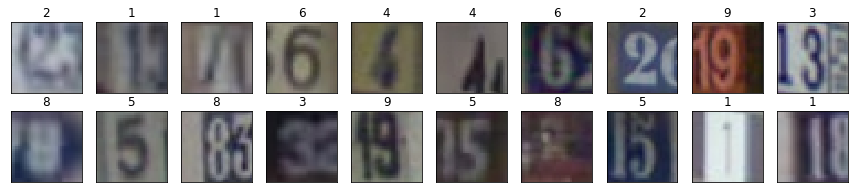

In [202]:
# visualize
images, labels = next(iter(train_loader))

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15, 3))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(str(labels[idx].item()))

In [0]:
# Preprocessor
def scale(x, feature_range=(-1, 1)):
    m, M = feature_range
    x = x * (M - m) + m  # x is originally [0,1]
    return x

## Model

### Discriminator

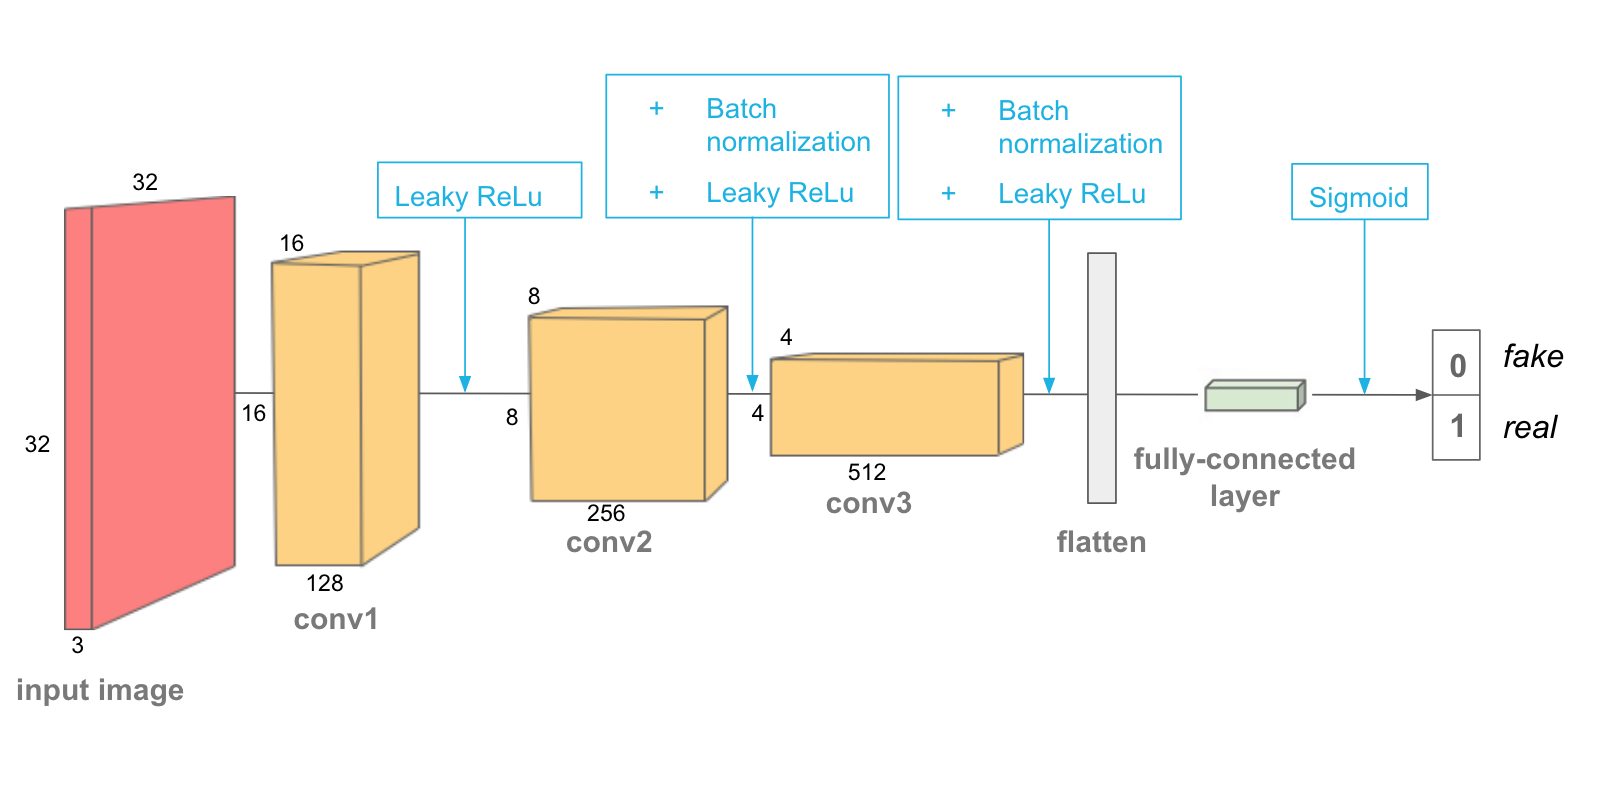
each layer should look something like convolution > batch norm > leaky ReLU, and so we'll define a function to put these layers together.

In [204]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):   # helper
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]
    if batch_norm: layers.append(nn.BatchNorm2d(out_channels))     
    return nn.Sequential(*layers)

class Discriminator(nn.Module):
    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim

       
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # in 32x32; out 16x16; first layer, no batch_norm        
        self.conv2 = conv(conv_dim, conv_dim*2, 4)          # in 16x16; out 8x8       
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)        # in 8x8  ; out 4x4
        
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        out = out.view(-1, self.conv_dim*4*4*4)
        out = self.fc(out)        
        return out

D = Discriminator(conv_dim=imgsize[1]).to(device)
print(D)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)


### Generator

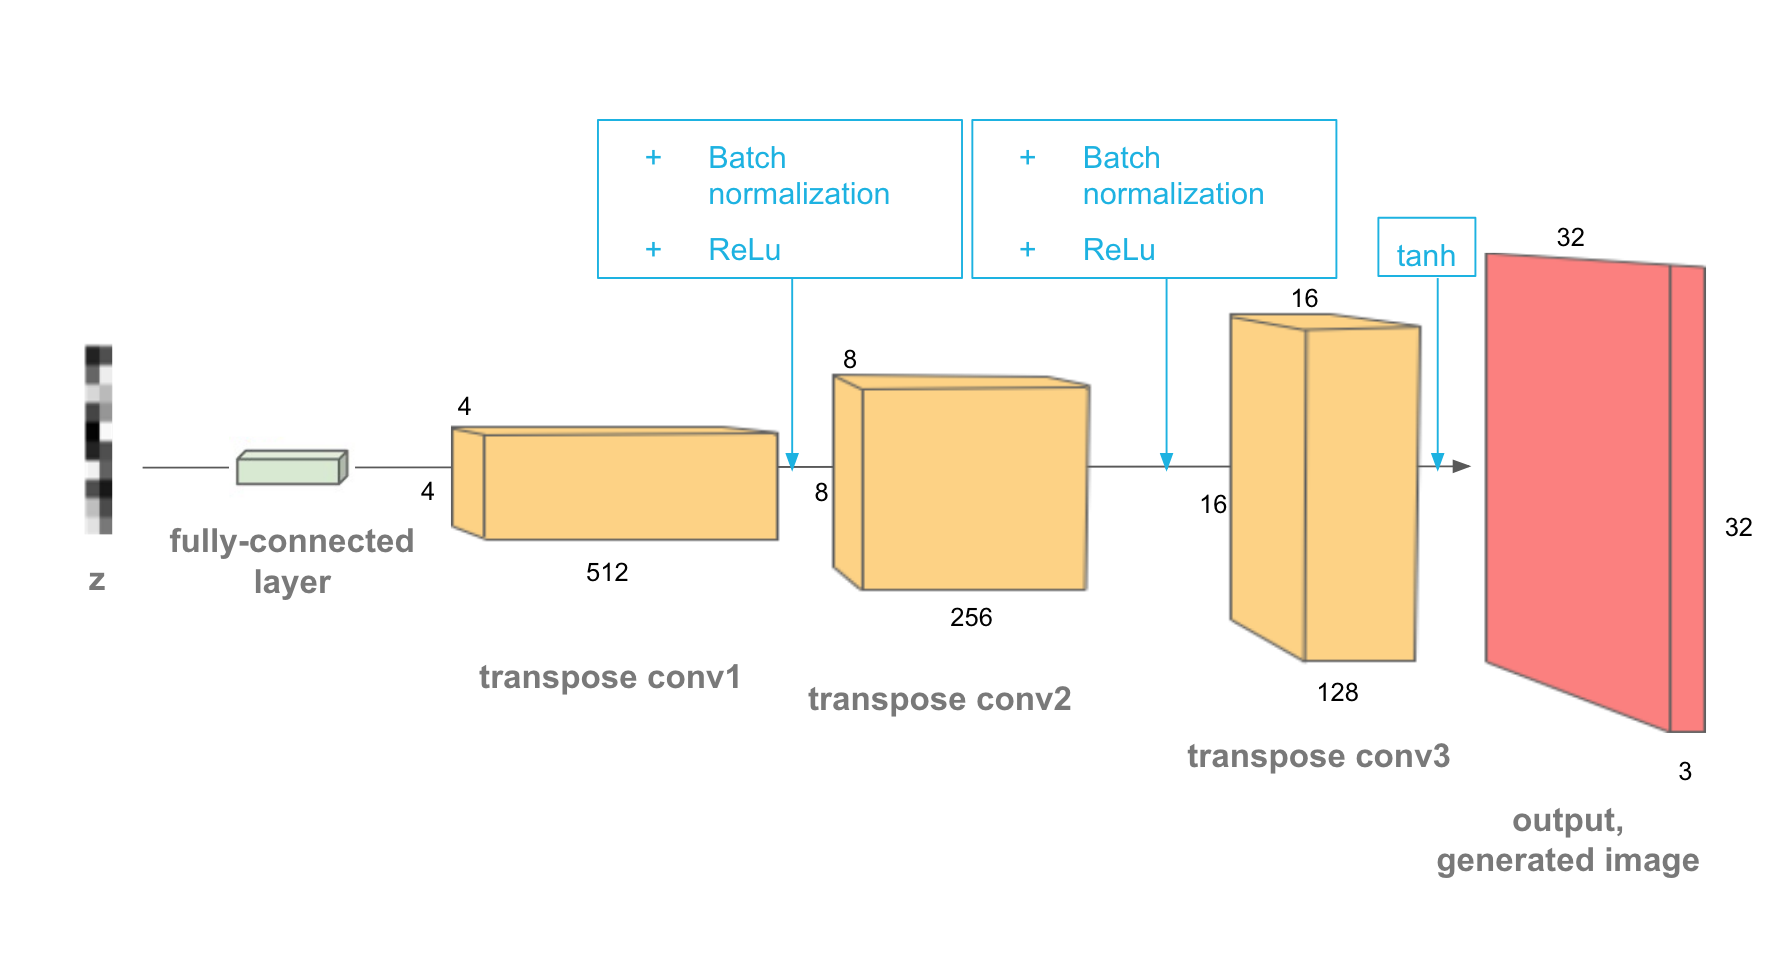

* output will be a nn.tanh output
* series of transpose convolutional layers, where you typically halve the depth and double the width and height of the previous layer.
* batch normalization and ReLU to all but the last of these hidden layers


In [205]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = [nn.ConvTranspose2d(in_channels, out_channels, 
                                 kernel_size, stride, padding, bias=False) ]
    if batch_norm: layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)

        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))        
        out = torch.tanh(self.t_conv3(out))
        
        return out
    
G = Generator(z_size=z_size, conv_dim=imgsize[1]).to(device)
print(G)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv3): Sequential(
    (0): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)


### Losses

* Use BCEWithLogitsLoss since D outputs just a number
* To help D generalize better, the true labels are **reduced from 1.0 to 0.9**
* Use different optimizer objects for Discriminator and Generator
* A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other

In [0]:
d_criterion = nn.BCEWithLogitsLoss()#lambda pred, true: fn(pred,true*0.9)
g_criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = torch.optim.Adam(G.parameters(), lr, [beta1, beta2])

## Train

In [0]:
# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=8
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
def view_samples(epoch, samples, nrows=2, ncols=4):
    fig, axes = plt.subplots(figsize=(1.5*ncols,1.5*nrows), nrows=nrows, ncols=ncols, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)), cmap='Greys_r')
    plt.show()

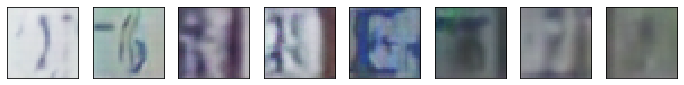

In [216]:
samples = []   # saves samples to visualize how the image quality improves over epochs

D.train()
G.train()
for epoch in range(epochs):
    for batch_i, (real_images, _) in enumerate(train_loader):                
        batch_size = real_images.size(0)        
        real_images = scale(real_images)  # to (-1,1)
        
        # ============TRAIN THE DISCRIMINATOR=========
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))  #generates fake img
        z = torch.from_numpy(z).float()
        fake_images = G(z.to(device))
        
        d_optimizer.zero_grad()
        
#         # Does NOT agree with DCGAN_Solution.ipynb because in train mode, BatchNormalization uses running mean/variance.
#         # passing real_images, fake_images as two separate batches affects it
#         allimages = torch.cat((real_images.to(device), fake_images), 0)
#         alllabels = torch.cat((torch.ones(batch_size),torch.zeros(batch_size)), 0).to(device)        
#         pred = D(allimages.to(device)).squeeze()
#         d_loss = 2*d_criterion(pred,alllabels)        
        pred_real = D(real_images.to(device)).squeeze()
        pred_fake = D(fake_images.to(device)).squeeze()
        d_loss = d_criterion(pred_real,torch.ones(batch_size).to(device)) +\
                 d_criterion(pred_fake,torch.zeros(batch_size).to(device))
        
        d_loss.backward()
        d_optimizer.step()  
        
        # ===========TRAIN THE GENERATOR=============
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))  #generates fake img
        z = torch.from_numpy(z).float()
        fake_images = G(z.to(device))
        
        g_optimizer.zero_grad()
        pred = D(fake_images.to(device)).squeeze()
        g_loss = g_criterion(pred, torch.ones(batch_size).to(device)) #min loss -> make D think the images are real        
        g_loss.backward()
        g_optimizer.step()      

        # =================OUTPUT====================
        if batch_i % print_every == 0:
            print(f'Epoch {epoch+1:5d} | d_loss: {d_loss.item():6.4f} | g_loss: {g_loss.item():6.4f}')
            
    from IPython.display import clear_output
    clear_output()
    G.eval()
    samples += G(fixed_z.to(device)),
    G.train()
    view_samples(-1,samples,1,8)

## Evaluate

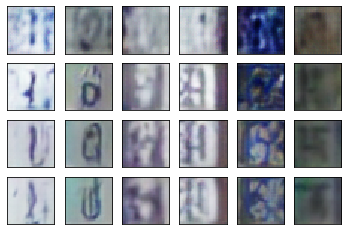

In [220]:
nrows = 4 # split epochs into 10, so 100/10 = every 10 epochs
ncols = 6
fig, axes = plt.subplots(figsize=(ncols,nrows), nrows=nrows, ncols=ncols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/nrows)], axes):
    for img, ax in zip(sample[::int(len(sample)/ncols)], ax_row):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.imshow(img.reshape((32,32,3)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)